#  MINST example - FC & CNN Models from scratch

In [1]:
from fastai.vision import *

## Load data

In [2]:
path = untar_data(URLs.MNIST)

In [3]:
path, path.ls(), (path/'testing').ls()

(PosixPath('/home/pczapla/.fastai/data/mnist_png'),
 [PosixPath('/home/pczapla/.fastai/data/mnist_png/models'),
  PosixPath('/home/pczapla/.fastai/data/mnist_png/training'),
  PosixPath('/home/pczapla/.fastai/data/mnist_png/testing')],
 [PosixPath('/home/pczapla/.fastai/data/mnist_png/testing/5'),
  PosixPath('/home/pczapla/.fastai/data/mnist_png/testing/3'),
  PosixPath('/home/pczapla/.fastai/data/mnist_png/testing/0'),
  PosixPath('/home/pczapla/.fastai/data/mnist_png/testing/4'),
  PosixPath('/home/pczapla/.fastai/data/mnist_png/testing/2'),
  PosixPath('/home/pczapla/.fastai/data/mnist_png/testing/9'),
  PosixPath('/home/pczapla/.fastai/data/mnist_png/testing/8'),
  PosixPath('/home/pczapla/.fastai/data/mnist_png/testing/7'),
  PosixPath('/home/pczapla/.fastai/data/mnist_png/testing/1'),
  PosixPath('/home/pczapla/.fastai/data/mnist_png/testing/6')])

load and convert to / interpret as black and white images ('L') https://pillow.readthedocs.io/en/3.1.x/reference/Image.html

In [4]:
il = ImageItemList.from_folder(path, convert_mode='RGB')

In [5]:
ds = il.split_by_folder(train='training', valid='testing')

In [6]:
ll = ds.label_from_folder(label_cls=CategoryList)

In [7]:
ll.train[0]

(Image (3, 28, 28), Category 5)

In [8]:
data = ll.databunch().normalize()

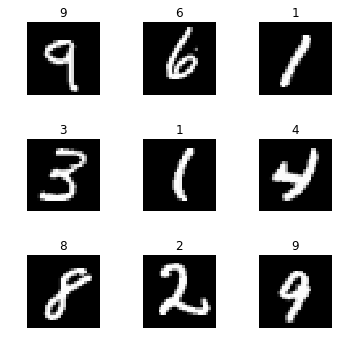

In [9]:
data.show_batch(rows=3, figsize=(5,5))

In [10]:
img,y = data.train_ds[6]

In [11]:
img

# Fully connected

In [12]:
xb,yb = next(iter(data.valid_dl))

In [13]:
xb.shape

torch.Size([64, 3, 28, 28])

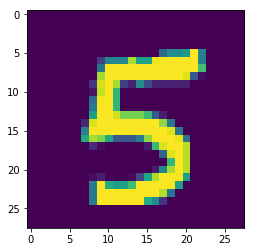

In [14]:
plt.imshow(xb[0,1, ...].squeeze());

In [15]:
xb[:,1,...].view(xb.shape[0],-1).shape

torch.Size([64, 784])

In [18]:
class FC(nn.Module):
    def forward(self, x):
        return x[:,1,...].view(x.shape[0],-1)

In [20]:
FC()(xb).shape

torch.Size([64, 784])

In [29]:
class FC(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(784, 1200),
            nn.ReLU(),
            nn.Linear(1200, 1200),
            nn.ReLU(),
            nn.Linear(1200, 1200),
            nn.ReLU(),
            nn.Linear(1200, 1200),
            nn.ReLU(),
            nn.Linear(1200, 10),
        )
    def forward(self, x):
        x = x[:,1,...].view(x.shape[0],-1)
        return self.net(x)

In [34]:
model=FC();model

FC(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=1200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1200, out_features=1200, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1200, out_features=1200, bias=True)
    (7): ReLU()
    (8): Linear(in_features=1200, out_features=10, bias=True)
  )
)

In [35]:
model(xb.cpu()).shape

torch.Size([64, 10])

In [36]:
learn = Learner(data, model.cuda())
learn.metrics = [error_rate]

In [37]:
print (f"Error rate: {learn.validate()[1]*100:0.4}%")

Error rate: 86.53%


In [38]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


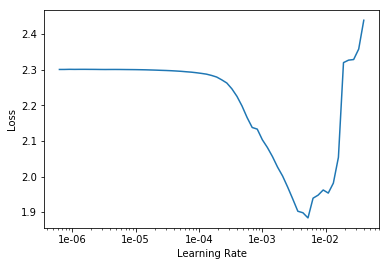

In [39]:
learn.recorder.plot()

In [40]:
learn.fit_one_cycle(4, 1e-3)

epoch,train_loss,valid_loss,error_rate
1,0.204042,0.222809,0.060900
2,0.133581,0.117153,0.028300
3,0.054844,0.070043,0.019700
4,0.019045,0.061198,0.014800


### Results

In [41]:
print (f"Error rate: {learn.validate()[1]*100:0.4}%")

Error rate: 1.48%


In [42]:
num_params = sum(p.numel() for p in learn.model.parameters())
print(f"Number of paramters {num_params//1000}k")

Number of paramters 5277k


In [43]:
learn.model

FC(
  (net): Sequential(
    (0): Linear(in_features=784, out_features=1200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1200, out_features=1200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=1200, out_features=1200, bias=True)
    (5): ReLU()
    (6): Linear(in_features=1200, out_features=1200, bias=True)
    (7): ReLU()
    (8): Linear(in_features=1200, out_features=10, bias=True)
  )
)

# A random ConvNet

In [44]:
xb[:,1,...].unsqueeze(1).shape

torch.Size([64, 1, 28, 28])

In [234]:
class CNN(nn.Module):
    def forward(self, x):
        return xb[:,1,...].unsqueeze(1)

In [255]:
PrepCNN()(xb.cpu()).shape

torch.Size([64, 1, 28, 28])

In [75]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(), 
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1), 
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size=3,stride=2),                     # 28/2 =14 
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2),                     # 14/2 = 7
            nn.Conv2d(256, 10, kernel_size=3, stride=1, padding=1),
            nn.AdaptiveAvgPool2d((1,1))
        )
    def forward(self, x):
        x = x[:,1,...].unsqueeze(1)
        return self.net(x).squeeze()

In [76]:
model=CNN().cuda()

In [77]:
model

CNN(
  (net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): AdaptiveAvgPool2d(output_size=(1, 1))
  )
)

In [78]:
model(xb).shape

torch.Size([64, 10])

In [79]:
num_params = sum(p.numel() for p in model.parameters())
print(f"Number of paramters {num_params//1000}k")

Number of paramters 392k


In [80]:
learn = Learner(data, model)
learn.metrics = [error_rate]

In [81]:
print (f"Error rate: {learn.validate()[1]*100:0.4}%")

Error rate: 89.91%


In [82]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


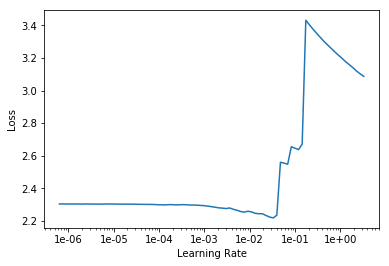

In [83]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(4, 1e-2)

epoch,train_loss,valid_loss,error_rate


### Results

In [ ]:
num_params = sum(p.numel() for p in learn.model.parameters())
print(f"Number of paramters {num_params//1000}k")

In [ ]:
print (f"Error rate: {learn.validate()[1]*100:0.4}%")

In [ ]:
learn.model

### Intrepretation

In [ ]:
interp = learn.interpret()

In [ ]:
interp.plot_top_losses(9, figsize=(7,7))

In [ ]:
interp.most_confused()

In [275]:
models.resnet18()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co